**Subscribe** to this channel and **follow** *@dsbyhadi* on twitter for updates!

*email: datasciencebyhadi@gmail.com*

----

### Sentiment analysis via Embedding and BOW, real scale.
#### Tool: fastText and sklearn

In [1]:
import fastText #version 0.8.22
import pandas as pd
import os
from fastText import train_supervised
import numpy as np

In [2]:
# To show the output of all lines in a cell rather that just the last line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [29]:
DATA_DIR = "/Users/hadi.minooei/Downloads/ft_amazon/" # Sometimes you might have to replace '~' with the complete path to resolve an error

Source: 
- https://www.kaggle.com/bittlingmayer/amazonreviews#train.ft.txt.bz2
- https://www.kaggle.com/bittlingmayer/amazonreviews#test.ft.txt.bz2

In [30]:
train_data = pd.read_table(DATA_DIR+"train.ft.txt", header=None, names=['sentence'])
train_data.shape

(3600000, 1)

In [31]:
pd.set_option('display.max_colwidth', -1)
train_data[5:8]

,sentence
5,"__label__2 an absolute masterpiece: I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs and quite a few songs (I haven't an exact count), all of which are heart-rendering and impressively remarkable, this soundtrack is one I assure you you will not forget. It has everything for every listener -- from fast-paced and energetic (Dancing the Tokage or Termina Home), to slower and more haunting (Dragon God), to purely beautifully composed (Time's Scar), to even some fantastic vocals (Radical Dreamers).This is one of the best videogame soundtracks out there, and surely Mitsuda's best ever. ^_^"
6,"__label__1 Buyer beware: This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I spent an evening with the book and a friend and we were in hysterics reading bits and pieces of it to one another. It is most definitely bad enough to be entered into some kind of a ""worst book"" contest. I can't believe Amazon even sells this kind of thing. Maybe I can offer them my 8th grade term paper on ""To Kill a Mockingbird""--a book I am quite sure Ms. Haddon never heard of. Anyway, unless you are in a mood to send a book to someone as a joke---stay far, far away from this one!"
7,"__label__2 Glorious story: I loved Whisper of the wicked saints. The story was amazing and I was pleasantly surprised at the changes in the book. I am not normaly someone who is into romance novels, but the world was raving about this book and so I bought it. I loved it !! This is a brilliant story because it is so true. This book was so wonderful that I have told all of my friends to read it. It is not a typical romance, it is so much more. Not reading this book is a crime, becuase you are missing out on a heart warming story."


`__label__1` is negative sentiment and `__label__2` is positive sentiment. As you can see labels are already fasttext-formatted!

In [36]:
test_data = pd.read_table(DATA_DIR+"test.ft.txt", header=None, names=['sentence'])
test_data.shape

(400000, 1)

train_data is too large for my machine (laptop). In practice, when your data is too large `sampling` is your friend! 

In this case I'm going to use test data for train/test(/validation) since it's large enough.

In [37]:
import re

def normalize(row):
    lower = row['sentence'].lower()
    #correct all multiple white spaces to a single white space
    no_mult_ws = re.sub('[\s]+', ' ', lower)
    text = no_mult_ws.strip()
    return text

In [38]:
test_data['normalized_sentence'] = test_data.apply(normalize, axis=1)

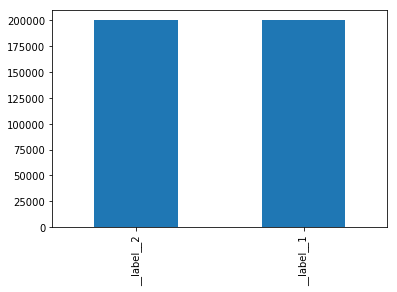

In [39]:
test_data['label'] = test_data['normalized_sentence'].apply(lambda row: row[0:10])
test_data['just_sentence'] = test_data['normalized_sentence'].apply(lambda row: row[10:])
test_data.drop(['sentence', 'normalized_sentence'], axis=1, inplace=True)
%matplotlib inline
test_data['label'].value_counts().plot(kind='bar')

In [40]:
test_data.head(3)

,label,just_sentence
0,__label__2,"great cd: my lovely pat has one of the great voices of her generation. i have listened to this cd for years and i still love it. when i'm in a good mood it makes me feel better. a bad mood just evaporates like sugar in the rain. this cd just oozes life. vocals are jusat stuunning and lyrics just kill. one of life's hidden gems. this is a desert isle cd in my book. why she never made it big is just beyond me. everytime i play this, no matter black, white, young, old, male, female everybody says one thing ""who was that singing ?"""
1,__label__2,"one of the best game music soundtracks - for a game i didn't really play: despite the fact that i have only played a small portion of the game, the music i heard (plus the connection to chrono trigger which was great as well) led me to purchase the soundtrack, and it remains one of my favorite albums. there is an incredible mix of fun, epic, and emotional songs. those sad and beautiful tracks i especially like, as there's not too many of those kinds of songs in my other video game soundtracks. i must admit that one of the songs (life-a distant promise) has brought tears to my eyes on many occasions.my one complaint about this soundtrack is that they use guitar fretting effects in many of the songs, which i find distracting. but even if those weren't included i would still consider the collection worth it."
2,__label__1,"batteries died within a year ...: i bought this charger in jul 2003 and it worked ok for a while. the design is nice and convenient. however, after about a year, the batteries would not hold a charge. might as well just get alkaline disposables, or look elsewhere for a charger that comes with batteries that have better staying power."


In [41]:
from sklearn.model_selection import train_test_split

dummy_train_data, dummy_test_data = train_test_split(test_data, test_size=0.35, random_state=4)

In [42]:
dummy_train_data.shape
dummy_test_data.shape

(260000, 2)

(140000, 2)

In [43]:
dummy_train_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon.train'), header=False, index=False, sep='\t')
dummy_test_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon.test'), header=False, index=False, sep='\t')

In [14]:
train_data_path = os.path.join(DATA_DIR, 'dummy_ft_amazon.train')
test_data_path = os.path.join(DATA_DIR, 'dummy_ft_amazon.test')

In [28]:
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))

In [54]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=2, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 8min 35s, sys: 2.81 s, total: 8min 37s
Wall time: 1min 23s
On train
N	260000
P@1	0.904
R@1	0.904
On test
N	140000
P@1	0.897
R@1	0.897


In [18]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=5, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ova", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 25min 4s, sys: 7.21 s, total: 25min 11s
Wall time: 3min 53s
On train
N	260000
P@1	0.915
R@1	0.915
On test
N	140000
P@1	0.901
R@1	0.901


###### Trying transfer learning:

For cells below, I downloaded english word embeddings of wikipedia (and some other sources) from fasttext website: https://fasttext.cc/docs/en/english-vectors.html

They have pretrained vectors for many other languages (157 languages as of June 2019): https://fasttext.cc/docs/en/crawl-vectors.html

In [12]:
wiki_vectors = "/Users/hadi.minooei/Downloads/wiki-news-300d-1M.vec"

with open(wiki_vectors) as f:
    for i in range(100):
        line = f.readline()
        print(line)

999994 300

, 0.1073 0.0089 0.0006 0.0055 -0.0646 -0.0600 0.0450 -0.0133 -0.0357 0.0430 -0.0356 -0.0032 0.0073 -0.0001 0.0258 -0.0166 0.0075 0.0686 0.0392 0.0753 0.0115 -0.0087 0.0421 0.0265 -0.0601 0.2420 0.0199 -0.0739 -0.0031 -0.0263 -0.0062 0.0168 -0.0357 -0.0249 0.0190 -0.0184 -0.0537 0.1420 0.0600 0.0226 -0.0038 -0.0675 -0.0036 -0.0080 0.0570 0.0208 0.0223 -0.0256 -0.0153 0.0022 -0.0482 0.0131 -0.6016 -0.0088 0.0106 0.0229 0.0336 0.0071 0.0887 0.0237 -0.0290 -0.0405 -0.0125 0.0147 0.0475 0.0647 0.0474 0.0199 0.0408 0.0322 0.0036 0.0350 -0.0723 -0.0305 0.0184 -0.0026 0.0240 -0.0160 -0.0308 0.0434 0.0147 -0.0457 -0.0267 -0.1703 -0.0099 0.0417 0.0235 -0.0260 -0.1519 -0.0116 -0.0306 -0.0413 0.0330 0.0723 0.0365 -0.0001 0.0042 0.0346 0.0277 -0.0305 0.0784 -0.0404 0.0187 -0.0225 -0.0206 -0.0179 -0.2428 0.0669 0.0523 0.0527 0.0149 -0.0708 -0.0987 0.0263 -0.0611 0.0302 0.0216 0.0313 -0.0140 -0.2495 -0.0346 -0.0480 0.0250 0.2130 -0.0330 -0.1553 -0.0292 -0.0346 0.1074 0.0010 -0.0117 -0.005

In [13]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.1, dim=300, epoch=2, loss='ns', bucket=200000, label="__label__", pretrainedVectors=wiki_vectors)
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 5min 38s, sys: 8.93 s, total: 5min 47s
Wall time: 4min 24s
On train
N	260000
P@1	0.910
R@1	0.910
On test
N	140000
P@1	0.894
R@1	0.894


In [14]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=2, loss='ns', bucket=200000, label="__label__", pretrainedVectors=wiki_vectors)
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 5min 34s, sys: 8.32 s, total: 5min 42s
Wall time: 4min 20s
On train
N	260000
P@1	0.909
R@1	0.909
On test
N	140000
P@1	0.893
R@1	0.893


In [25]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=5, loss='ns', bucket=200000, label="__label__", pretrainedVectors=wiki_vectors)
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 8min 7s, sys: 7.35 s, total: 8min 14s
Wall time: 4min 41s
On train
N	260000
P@1	0.925
R@1	0.925
On test
N	140000
P@1	0.896
R@1	0.896


Looks like more epochs is now causing overfitting..

In [15]:
%time amazon_sentiment_model_transfer = train_supervised(input=train_data_path, lr=0.9, dim=300, epoch=2, minn=3, maxn=4, loss='ns', bucket=200000, label="__label__", pretrainedVectors=wiki_vectors)
print("On train")
print_results(*amazon_sentiment_model_transfer.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model_transfer.test(test_data_path))

CPU times: user 18min 21s, sys: 14.6 s, total: 18min 36s
Wall time: 6min 52s
On train
N	260000
P@1	0.905
R@1	0.905
On test
N	140000
P@1	0.897
R@1	0.897


I go with P@1 ~ 0.91 train and P@1 ~ 0.9 test $\uparrow$

### Experimenting with removing punctuations

In [21]:
import re
import string

def normalize(row, col_name):
    lower = row[col_name].lower()
    #correct all multiple white spaces to a single white space
    no_mult_ws = re.sub('[\s]+', ' ', lower)
    striped = no_mult_ws.strip()
    #remove punctuations
    no_punc = striped.translate(str.maketrans('', '', string.punctuation))
    return no_punc

In [22]:
test_data = pd.read_table(DATA_DIR+"test.ft.txt", header=None, names=['label_sentence'])

test_data['label'] = test_data['label_sentence'].apply(lambda row: row[0:10])
test_data['sentence'] = test_data['label_sentence'].apply(lambda row: row[10:])
test_data['normalized_sentence'] = test_data.apply(lambda row: normalize(row, 'sentence'), axis=1)

test_data.drop(['label_sentence', 'sentence'], axis=1, inplace=True)

In [23]:
test_data.head(3)

,label,normalized_sentence
0,__label__2,great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing
1,__label__2,one of the best game music soundtracks for a game i didnt really play despite the fact that i have only played a small portion of the game the music i heard plus the connection to chrono trigger which was great as well led me to purchase the soundtrack and it remains one of my favorite albums there is an incredible mix of fun epic and emotional songs those sad and beautiful tracks i especially like as theres not too many of those kinds of songs in my other video game soundtracks i must admit that one of the songs lifea distant promise has brought tears to my eyes on many occasionsmy one complaint about this soundtrack is that they use guitar fretting effects in many of the songs which i find distracting but even if those werent included i would still consider the collection worth it
2,__label__1,batteries died within a year i bought this charger in jul 2003 and it worked ok for a while the design is nice and convenient however after about a year the batteries would not hold a charge might as well just get alkaline disposables or look elsewhere for a charger that comes with batteries that have better staying power


In [24]:
from sklearn.model_selection import train_test_split

dummy_train_data, dummy_test_data = train_test_split(test_data, test_size=0.35, random_state=4)

In [41]:
dummy_train_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon_punc.train'), header=False, index=False, sep='\t')
dummy_test_data.to_csv(path_or_buf=os.path.join(DATA_DIR, 'dummy_ft_amazon_punc.test'), header=False, index=False, sep='\t')

In [20]:
train_data_path = '~/Downloads/ft_amazon/dummy_ft_amazon_punc.train'
test_data_path = '~/Downloads/ft_amazon/dummy_ft_amazon_punc.test'

In [42]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=2, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 8min 4s, sys: 4.11 s, total: 8min 8s
Wall time: 1min 18s
On train
N	260000
P@1	0.900
R@1	0.900
On test
N	140000
P@1	0.894
R@1	0.894


In [43]:
%time amazon_sentiment_model = train_supervised(input=train_data_path, lr=0.9, dim=200, ws=5, epoch=5, minn=3, maxn=4, neg=5, wordNgrams=1, loss="ns", bucket=200000)

print("On train")
print_results(*amazon_sentiment_model.test(train_data_path))
print("On test")
print_results(*amazon_sentiment_model.test(test_data_path))

CPU times: user 20min 50s, sys: 7.87 s, total: 20min 58s
Wall time: 3min 22s
On train
N	260000
P@1	0.907
R@1	0.907
On test
N	140000
P@1	0.898
R@1	0.898


Potentially further grid_search finds better solutions...

### Experimenting with BOW

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

Using params from the previous example to start..

In [19]:
text_classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words=None, ngram_range=(1, 2), max_features=50000, binary=False)),
    ('tfidf', TfidfTransformer(norm='l2', use_idf=True)),
    ('clf', LogisticRegression(penalty='l1', C=0.9, random_state=21)),
])

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     test_data.normalized_sentence, test_data.label, test_size=0.35, random_state=4)

In [21]:
%time text_classifier.fit(X_train, y_train) 

CPU times: user 1min 27s, sys: 3.31 s, total: 1min 30s
Wall time: 1min 30s


Pipeline(steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
      ...alty='l1', random_state=21, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [22]:
from sklearn import metrics

predicted_train = text_classifier.predict(X_train)

y_train = y_train.astype('category')
print(metrics.classification_report(y_train, predicted_train,
    labels=y_train.cat.categories.tolist()))

metrics.confusion_matrix(y_train, predicted_train)

predicted_test = text_classifier.predict(X_test)

y_test = y_test.astype('category')
print(metrics.classification_report(y_test, predicted_test,
    labels=y_test.cat.categories.tolist()))

metrics.confusion_matrix(y_test, predicted_test)

             precision    recall  f1-score   support

 __label__1       0.93      0.93      0.93    130114
 __label__2       0.93      0.93      0.93    129886

avg / total       0.93      0.93      0.93    260000



array([[120980,   9134],
       [  8752, 121134]])

             precision    recall  f1-score   support

 __label__1       0.92      0.92      0.92     69886
 __label__2       0.92      0.92      0.92     70114

avg / total       0.92      0.92      0.92    140000



array([[64220,  5666],
       [ 5310, 64804]])

Gonna go with these params as they are already beating the above model.. (prec 0.93 on train (vs. 0.91 above) and prec 0.92 on test (vs. 0.9 above))

*In my next iteration I would Not lower case the text when normalizing and use fasttext-transfer learning (with wiki-news vectors). What would be your next iteration?*